# <div style="text-align: center"> Taller 1 </div>  
<div style="text-align: center"> Alejandro Alayón Suárez - 201316083</div>
___

<div style="text-align: justify"> Para el desarrollo del presente taller se utilizó una serie de funciones auxiliares con el objetivo de facilitar la construcción de los modelos matemáticos requeridos para el cálculo de ajustes, errores e indicadores del mercado energético. Dichas funciones son explicadas con mayor detalle a continuación.</div> 

In [2]:
import os
import pandas as pd
import scipy as sp
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<div style="text-align: justify">La primer función auxiliar utilizada fue denominada **_importdata_**. Esta recibe como parámetro el nombre de la ciudad de donde se quieren importar los datos de radiación y retorna un arreglo de dos posiciones en el cual se encuentran los datos históricos del IDEAM y del NREL respectivamente. </div><br/>

<div style="text-align: justify"> Los datos están disponibles para las siguientes ciudades (escritas tal como aparecen en los directorios):</div>

* Barranquilla
* Cali
* Carmendebolivar
* Medellin
* SantaMarta
* Sucre
* Uribia
* Valledupar

In [6]:
def importdata(ciudad):
    
    base_dir = os.path.join( '.','data')
    fuente1 = 'IDEAM'
    fuente2 = 'NREL'
    serie_csv1 = os.path.join(base_dir,ciudad,fuente1+'.csv')
    serie_pd1 = pd.read_csv(serie_csv1, sep = ';',
                    encoding='latin-1')
    serie_csv2 = os.path.join(base_dir,ciudad,fuente2+'.csv')
    serie_pd2 = pd.read_csv(serie_csv2, sep = ';',
                    encoding='latin-1')
    
    return serie_pd1, serie_pd2
    

<div style="text-align: justify">La segunda función auxiliar utilizada fue denominada **_datapiece_**. Esta recibe como parámetros una lista de datos y dos fechas en la forma: _año inicial, año final, mes inicial, mes final, día inicial y día final_. Con base en esto, la función retorna la misma lista de datos ingresada recortada entre el intervalo de tiempo indicado. </div>

In [8]:
def datapiece(data, year1, year2, month1, month2, day1, day2):
    piece=data[(data['AÑO']>=year1) & (data['AÑO']<=year2)
            & (data['MES']>=month1) & (data['MES']<=month2)
            & (data['DIA']>=day1) & (data['DIA']<=day2)]
    return piece

<div style="text-align: justify">La tercera función auxiliar utilizada fue denominada **_datadj_**. Esta recibe como parámetros dos listas de datos y tiene como propósito ajustar el tamaño y temporalidad de la primera con respecto a la segunda. Esto permite que las listas puedan ser comparables entre si ya que la función retorna la primera lista ajustada. </div>

In [22]:
#La variable de entrada data2 es IDEAM
def datadj(data1,data2):
    data1_adj=data1[(data1['AÑO']>=data2.iloc[0,0]) & (data1['AÑO']<=data2.iloc[-1,0])
            & (data1['MES']>=data2.iloc[0,1]) & (data1['MES']<=data2.iloc[-1,1])
            & (data1['DIA']>=data2.iloc[0,2]) & (data1['DIA']<=data2.iloc[-1,2])]
    
    return data1_adj


<div style="text-align: justify">Finalmente, la cuarta función auxiliar utilizada fue denominada **_ghi__monthavg_**. Esta recibe como parámetro una lista histórica de la radiación horaría para un lugar y espacio de tiempo determinados. La función calcula el promedio de radiación diario para cada mes en [kW/día] y retorna una lista con dichos promedios para todos los años de la función original. </div> 

In [9]:
def ghi_monthavg(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_dia = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/(dias[-1]*1000)
            ghi_dict = {"AÑO":agno, "MES":mes,
                        "GHIdiario":ghi_dia}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df


### 1. Implementación de la función de energía firme para el Cargo por Confiabilidad (ENFICC)
___
<div style="text-align: justify">Para el cálculo de la ENFICC se implementó la función mostrada a continuación. Esta recibe como parámetro una lista histórica de radiación horaría, a esta le aplica la función _ghi__monthavg_ y procede a calcular el percentil al 1% de la lista. Es decir, se obtiene el valor para el cual el 99% de los datos restantes son mayores . </div> 

In [39]:
def ENFICC(data1):
    
    ghi_diario_loc = ghi_monthavg(data1)
    percentil = 0.01
    enficc = ghi_diario_loc.quantile(q=percentil, 
                                     numeric_only=True)["GHIdiario"]

    return enficc


### 2. Implementación de la función de graficación de la distribución de la energía promedio diaria
___
<div style="text-align: justify">Con el objetivo de graficar la distribución del promedio de la radiación diaria para cada mes se implementó la función mostrada a continuación. Esta tiene como parámetros de entrada tres series de datos las cuales deben ser introducidas en el sigiente orden: _datos originales del IDEAM, datos ajustados del NREL y datos originales del NREL_. Si la función es utilizada adecuadamente retorna un grafico, normalizado con respeto a la primera serie, de la distribución ordenada de menor a mayor del promedio diario mes a mes para las series dadas.</div> 

In [245]:
def graphED(arrayIDEAM,arrayNRELMOD,arrayNREL,Titulo):
    
    NRELMODadj=datadj(arrayNRELMOD,arrayIDEAM)
    NRELadj=datadj(arrayNREL,arrayIDEAM)

    ghi_diario_loc1 = ghi_monthavg(arrayIDEAM)    
    datos_IDEAM1 = sorted(ghi_diario_loc1["GHIdiario"])
    numdatos1 = range(len(datos_IDEAM1))

    ghi_diario_loc2 = ghi_monthavg(NRELMODadj)    
    datos_IDEAM2 = sorted(ghi_diario_loc2["GHIdiario"])
    numdatos2 = range(len(datos_IDEAM2))

    ghi_diario_loc3 = ghi_monthavg(NRELadj)    
    datos_IDEAM3 = sorted(ghi_diario_loc3["GHIdiario"])
    numdatos3 = range(len(datos_IDEAM3))

    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    
    pylab.plot(numdatos1,datos_IDEAM1/datos_IDEAM1[0],'-k', label='IDEAM')
    pylab.plot(numdatos2,datos_IDEAM2/datos_IDEAM1[0],'-b', label='NRELMOD')
    pylab.plot(numdatos3,datos_IDEAM3/datos_IDEAM1[0],'-r', label='NREL')
        
    pylab.legend(loc='upper left')
    pylab.title(Titulo)
    
    return pylab.plot()


### 3. Implementación de la función de Medicion-Correlación-Predicción (MCP)
___
<div style="text-align: justify">Con el objetivo de ajustar una serie mediante la metodología del MCP basada en la realción de varianzas se implementó la función mostrada a continuación. Esta tiene como parámetros de entrada dos series de datos las cuales deben ser introducidas en el sigiente orden: _serie de referencia y serie corta_. Dicha función retorna una nueva serie del tamaño de la de referencia pero ajustada con respecto a la razón de las varianzas de las dos. En los comentarios incluidos dentro del cuerpo de la función se explica el fin de cada bloque de código.</div>


In [24]:
def MCP(data_ref,data_obj):
    
    #Extrae los datos de referenia en el intervalo de tiempo de los datos objetivo 
    data_ref_adj=datadj(data_ref,data_obj)
    #Calcula los estadísticos de los datos en el periodo común
    mu_obj=data_obj['IDEAM'].mean()
    sigma_obj=data_obj['IDEAM'].std()
    mu_ref=data_ref_adj['NREL'].mean()
    sigma_ref=data_ref_adj['NREL'].std()
    
    #Calcula los parámetros del modelo
    m=sigma_obj/sigma_ref
    b=mu_obj-m*mu_ref
    
    #Aplica el modelo remplazando los valores negativos con 0
    data_ref_cor=data_ref['NREL']*m+b
    data_ref_cor[data_ref_cor < 0] = 0
    
    dat2 = pd.DataFrame({'NRELMOD': data_ref_cor})
    newdata=data_ref.join(dat2['NRELMOD'])
    
               
    return newdata


### 4. Implementación de las funciónes de los indicadores de error RMSEn, MBE y KSI 
___

<div style="text-align: justify">Con el objetivo de calcular los errores entre dos series se implementaron las funciones listadas a continuación. Estas tienen como parámetros de entrada dos series de datos y dos nombres de las columnas a comparar, estas deben ser introducidas en el sigiente orden: _primera serie, nombre de la columna de la primera serie y segunda serie (usualmente IDEAM), nombre de la columna de la segunda serie_. Dichas funciónen retornan el valor del error asociado a cada par de series. La única excepción es el indicador de error KSI ya que este retorna el p-value el cual puede ser interpretado como un menos cuando su valor se acerca a 1.</div>


In [25]:
def RMSEn(data1,column1,data2,column2):
    
    #Ajusta la primera lista de datos para que concuerde con el periodo de la segunda lista
    data1_adj=datadj(data1,data2)
    
    #Aplica la función de error cuadratico medio normalizado paso a paso
    fst=(data1_adj[column1]-data2[column2])**2
    N=len(data2.index)
    scnd=sqrt(fst.sum()/N)
    x_d2_max=data2[column2].max()
    x_d2_min=data2[column2].min()
    rmsen=scnd/(x_d2_max-x_d2_min)
    
    return rmsen

In [84]:
def MBE(data1,column1,data2,column2):
    
    #Ajusta la primera lista de datos para que concuerde con el periodo de la segunda lista
    data1_adj=datadj(data1,data2)
    
    #Aplica la función de error de sesgo medio paso a paso
    fst=(-data1_adj[column1]+data2[column2])
    scnd=data2[column2].sum()
    mbe=fst.sum()/scnd
    
    return mbe

In [27]:
def KSI(data1,column1,data2,column2):
    
    #Ajusta la primera lista de datos para que concuerde con el periodo de la segunda lista
    data1_adj=datadj(data1,data2)
    
    #Aplica la función de error de sesgo medio paso a paso
    ksi=sp.stats.ks_2samp(data1_adj[column1],data2[column2])
    return ksi[1]

### 5. Análisis de resultados
___
<div style="text-align: justify"> Para determinar la eficacia del metodo MCP se deben analizar los factores que influyen en la estimación de las series de tiempo. Entre estos se encuentran: la localización geográfica, el periodo de tiempo de observación y el año utilizado para dicho ajuste..</div>

#### 5.1 Influencia del periodo de observación
<br><div style="text-align: justify"> Para determinar la influencia del periodo de observación se utilizó la ciudad de Barranquilla entre los años 2010 y 2014 comprendiendo periodos desde 3 hasta 9 meses. Los resultados encontrados son expuestos acontinuación .</div>

In [133]:
pd.read_pickle(os.path.join(output_dir,'2010'))

,2010,Error ENFICC [%],KSI [p-val],MBE [%],RMSEn [%]
0,NREL,10.70,8.910637e-17,1.39,4.84
1,3 meses,2.46,4.474547e-34,2.56,4.93
2,6 meses,0.84,2.718893e-58,3.04,5.00
3,9 meses,6.50,4.013214e-13,1.97,4.88
4,12 meses,3.89,1.071048e-24,2.34,4.91


In [134]:
pd.read_pickle(os.path.join(output_dir,'2011'))

,2011,Error ENFICC [%],KSI [p-val],MBE [%],RMSEn [%]
0,NREL,10.70,8.910637e-17,1.39,4.84
1,3 meses,22.66,0.000000e+00,-0.34,4.97
2,6 meses,17.97,0.000000e+00,0.38,4.85
3,9 meses,20.09,0.000000e+00,0.04,4.91
4,12 meses,19.85,2.634947e-61,0.06,4.92


In [135]:
pd.read_pickle(os.path.join(output_dir,'2012'))

,2012,Error ENFICC [%],KSI [p-val],MBE [%],RMSEn [%]
0,NREL,10.70,8.910637e-17,1.39,4.84
1,3 meses,16.84,0.000000e+00,0.52,4.86
2,6 meses,11.99,8.289425e-23,1.17,4.86
3,9 meses,10.81,5.496246e-19,1.33,4.86
4,12 meses,5.31,1.846041e-19,2.11,4.90


In [136]:
pd.read_pickle(os.path.join(output_dir,'2013'))

,2013,Error ENFICC [%],KSI [p-val],MBE [%],RMSEn [%]
0,NREL,10.70,8.910637e-17,1.39,4.84
1,3 meses,14.83,1.141934e-41,0.68,4.93
2,6 meses,9.28,1.576333e-20,1.52,4.88
3,9 meses,12.56,3.656569e-26,1.08,4.87
4,12 meses,12.81,6.291686e-27,1.05,4.86


In [153]:
pd.read_pickle(os.path.join(output_dir,'2014'))

,2014,Error ENFICC [%],KSI [p-val],MBE [%],RMSEn [%]
0,NREL,10.70,8.910637e-17,1.39,4.84
1,3 meses,11.23,3.205812e-20,1.28,4.86
2,6 meses,5.05,1.576333e-20,2.14,4.91
3,9 meses,1.41,2.673961e-31,2.66,4.96
4,12 meses,1.75,3.193386e-30,2.61,4.95


<div style="text-align: justify"> La primera fila de las tablas indica el error porcentual de la serie del NREL con respecto a la del IDEAM. Las filas siguientes son los errores de las series tomando diferentes tramos de tiempo para el ajuste MCP. Es evidenciable (en la mayoría de los casos) que entre mayor sea el periodo de tiempo observado el error en el ENFICC disminuye, esto era de esperarse ya que el MCP tiene un mayor número de datos para trabajar y por ende produce una estimación más acertada. Por facilidad se considera que un año de datos observados es adecuado para el ajuste ya que puede disminuir el error en el cálculo del ENFICC hasta un valor de 1.75%. Ahora bien, los casos en los cuales el error es mayor a medida que aumenta el tiempo observado pueden deberse a externalidades climáticas propias de dichos años.</div><br>

<div style="text-align: justify"> Con respecto a los demás errores se puede ver que su valor (el cual se puede considerar pequeño) no varía significativamente entre periodos de tiempo de observación, esto quiere decir que debido a que estos errores son calculados punto a punto un valor de temporalidad diferente no afecta directamente el promedio de dichos errores si no, la distribución en general de la serie. Esto explica no solamente porqué disminuye el ENFICC, sino también el comportamiento del KSI.</div> 


#### 5.2 Influencia del año de observación
<br><div style="text-align: justify"> Para determinar la influencia del año de observación se utilizaron las ciudades de Cali, Medellin y Santa Marta entre los años 2008 y 2015 con periodos de un año de observación. En ellas se calculó el error del cálculo del ENFICC con respecto a la serie reportada por el IDEAM.</div>


In [212]:
pd.read_pickle(os.path.join(output_dir,'2008_2'))

,2008,Cali,Medellin,Santa Marta
0,Error ENFICC NREL [%],30.93,22.37,12.26
1,Error ENFIC NRELMOD [%],10.21,2.14,3.10
2,Disminución del error [%],20.72,20.23,9.16


In [213]:
pd.read_pickle(os.path.join(output_dir,'2009_2'))

,2009,Cali,Medellin,Santa Marta
0,Error ENFICC NREL [%],30.93,22.37,12.26
1,Error ENFIC NRELMOD [%],7.30,4.63,0.61
2,Disminución del error [%],23.63,17.74,11.65


In [214]:
pd.read_pickle(os.path.join(output_dir,'2010_2'))

,2010,Cali,Medellin,Santa Marta
0,Error ENFICC NREL [%],30.93,22.37,12.26
1,Error ENFIC NRELMOD [%],8.59,3.43,1.70
2,Disminución del error [%],22.34,18.94,10.56


In [215]:
pd.read_pickle(os.path.join(output_dir,'2011_2'))

,2011,Cali,Medellin,Santa Marta
0,Error ENFICC NREL [%],30.93,22.37,12.26
1,Error ENFIC NRELMOD [%],6.61,4.79,15.93
2,Disminución del error [%],24.32,17.58,-3.67


In [216]:
pd.read_pickle(os.path.join(output_dir,'2012_2'))

,2012,Cali,Medellin,Santa Marta
0,Error ENFICC NREL [%],30.93,22.37,12.26
1,Error ENFIC NRELMOD [%],10.43,5.27,4.21
2,Disminución del error [%],20.50,17.10,8.05


In [218]:
pd.read_pickle(os.path.join(output_dir,'2013_2'))

,2013,Cali,Medellin,Santa Marta
0,Error ENFICC NREL [%],30.93,22.37,12.26
1,Error ENFIC NRELMOD [%],7.10,1.62,6.91
2,Disminución del error [%],23.83,20.75,5.35


In [219]:
pd.read_pickle(os.path.join(output_dir,'2014_2'))

,2014,Cali,Medellin,Santa Marta
0,Error ENFICC NREL [%],30.93,22.37,12.26
1,Error ENFIC NRELMOD [%],9.75,2.48,14.63
2,Disminución del error [%],21.18,19.89,-2.37


In [224]:
pd.read_pickle(os.path.join(output_dir,'2015_2'))

,2015,Cali,Medellin,Santa Marta
0,Error ENFICC NREL [%],30.93,22.37,12.26
1,Error ENFIC NRELMOD [%],16.70,19.16,18.19
2,Disminución del error [%],14.23,3.21,-5.93


<div style="text-align: justify"> Tal como se aprecia en las tablas anteriores, el año utilizado para el ajuste influye ampliamente en la disminución del error al aplicar el MCP, esto se debe a los fenómenos climáticos de periodicidad no anual tal como lo son el fenómeno de la Niña y el Niño. Sin embargo vale resaltar que tanto para la mayoría de los años, como para la mayoría de las ciudades analizadas el MCP permite una diminución en el error del cálculo de la ENFICC lo que valida el uso de la herramienta.</div>

#### 5.3 Influencia de la localización
<br><div style="text-align: justify"> Para determinar la influencia de la localización geográfica se utilizaron los datos observados duarante el año 2013 (libre del fenómeno de la Niña y el Niño) para todas las ciudades disponibles.</div>

In [236]:
pd.read_pickle(os.path.join(output_dir,'2013_3'))

,2013,Barranquilla,Cali,Carmen de Bolivar,Medellin,Santa Marta,Sucre,Uribia,Valledupar
0,Error ENFICC NREL [%],10.70,30.93,5.14,22.37,12.26,103.39,7.95,10.80
1,Error ENFIC NRELMOD [%],11.36,7.10,7.08,1.62,6.91,48.37,1.17,7.58
2,Disminución del error [%],-0.66,23.83,-1.94,20.75,5.35,55.02,6.78,3.22


[]

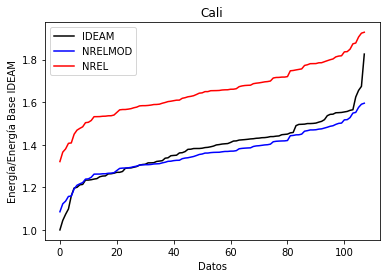

In [247]:
graphED(IDEAM_CLO,NRELMOD_CLO_12MO,NREL_CLO,'Cali')

[]

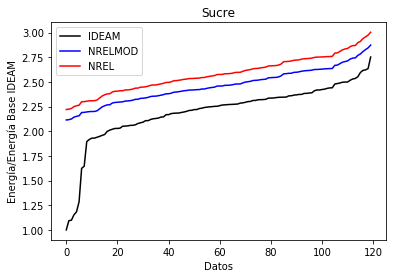

In [250]:
graphED(IDEAM_CZU,NRELMOD_CZU_12MO,NREL_CZU,'Sucre')

[]

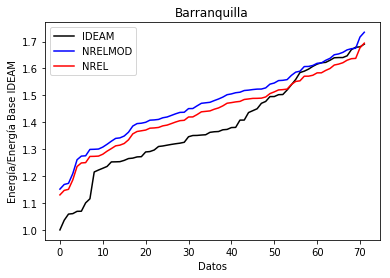

In [249]:
graphED(IDEAM_BAQ,NRELMOD_BAQ_12MO,NREL_BAQ,'Barranquilla')

<br><div style="text-align: justify">Los resultados anteriormente mostrados demuestran que la localización geográfica puede tener un gran impacto a la hora de minimizar los errores al aplicar un ajuste MCP. Tal como se aprecia en la tabla existen dos lugares para los cuales el error del ENFICC aumenta al ajustar la serie del NREL. Esto puede ser causado por la aparente convergencia de las series del IDEAM y del NREL para dichos lugares tal como se observa en la gráfica de Barranquilla. Sin embargo, en la mayoría de los casos los datos del NREL sobre estiman la radiación de manera constante y por lo tanto al ser ajustados mediante el MCP ayudan a disminuir significativamente el error presentado en el ENFICC.</div>

### 6. Conclusiones
----

<br><div style="text-align: justify">Para concluir, es importante considerar los factores anteriormente nombrados: periodo de observación, año de observación y lugar de observación. Ya que estos afectan directamente la credibilidad del ajuste por MCP para el cálculo del ENFICC. Como recomendaciones generales se debe optar por hacer el ajuste con el mayor tiempo de observación posible, en años que no presenten fenómenos del Niño y Niña y en lugares donde los datos satelitales mantengan una sobreestimación estable de la radiación.</div>


### 7. Código utilizado para los cálculos del análisis de resultados
----

In [31]:
IDEAM_BAQ=importdata('Barranquilla')[0]
NREL_BAQ=importdata('Barranquilla')[1]
IDEAM_CLO=importdata('Cali')[0]
NREL_CLO=importdata('Cali')[1]
IDEAM_CDV=importdata('Carmendebolivar')[0]
NREL_CDV=importdata('Carmendebolivar')[1]
IDEAM_MDE=importdata('Medellin')[0]
NREL_MDE=importdata('Medellin')[1]
IDEAM_SMR=importdata('SantaMarta')[0]
NREL_SMR=importdata('SantaMarta')[1]
IDEAM_CZU=importdata('Sucre')[0]
NREL_CZU=importdata('Sucre')[1]
IDEAM_URA=importdata('Uribia')[0]
NREL_URA=importdata('Uribia')[1]
IDEAM_VUP=importdata('Valledupar')[0]
NREL_VUP=importdata('Valledupar')[1]

In [145]:
año=2015
IDEAM_BAQ_3MO=datapiece(IDEAM_BAQ, año, año, 1, 3, 1, 1)
IDEAM_BAQ_6MO=datapiece(IDEAM_BAQ, año, año, 1, 6, 1, 1)
IDEAM_BAQ_9MO=datapiece(IDEAM_BAQ, año, año, 1, 9, 1, 1)
IDEAM_BAQ_12MO=datapiece(IDEAM_BAQ, año, año, 1, 12, 1, 1)

In [156]:
NRELMOD_BAQ_3MO=MCP(NREL_BAQ,IDEAM_BAQ_3MO)
NRELMOD_BAQ_6MO=MCP(NREL_BAQ,IDEAM_BAQ_6MO)
NRELMOD_BAQ_9MO=MCP(NREL_BAQ,IDEAM_BAQ_9MO)
NRELMOD_BAQ_12MO=MCP(NREL_BAQ,IDEAM_BAQ_12MO)

In [147]:
a=ENFICC(IDEAM_BAQ)
b=ENFICC(NREL_BAQ)
c=ENFICC(NRELMOD_BAQ_3MO)
d=ENFICC(NRELMOD_BAQ_6MO)
e=ENFICC(NRELMOD_BAQ_9MO)
f=ENFICC(NRELMOD_BAQ_12MO)

In [148]:
a1=RMSEn(NREL_BAQ,'NREL',IDEAM_BAQ,'IDEAM')
b1=RMSEn(NRELMOD_BAQ_3MO,'NRELMOD',IDEAM_BAQ,'IDEAM')
c1=RMSEn(NRELMOD_BAQ_6MO,'NRELMOD',IDEAM_BAQ,'IDEAM')
d1=RMSEn(NRELMOD_BAQ_9MO,'NRELMOD',IDEAM_BAQ,'IDEAM')
e1=RMSEn(NRELMOD_BAQ_12MO,'NRELMOD',IDEAM_BAQ,'IDEAM')

In [149]:
a2=MBE(NREL_BAQ,'NREL',IDEAM_BAQ,'IDEAM')
b2=MBE(NRELMOD_BAQ_3MO,'NRELMOD',IDEAM_BAQ,'IDEAM')
c2=MBE(NRELMOD_BAQ_6MO,'NRELMOD',IDEAM_BAQ,'IDEAM')
d2=MBE(NRELMOD_BAQ_9MO,'NRELMOD',IDEAM_BAQ,'IDEAM')
e2=MBE(NRELMOD_BAQ_12MO,'NRELMOD',IDEAM_BAQ,'IDEAM')

In [150]:
a3=KSI(NREL_BAQ,'NREL',IDEAM_BAQ,'IDEAM')
b3=KSI(NRELMOD_BAQ_3MO,'NRELMOD',IDEAM_BAQ,'IDEAM')
c3=KSI(NRELMOD_BAQ_6MO,'NRELMOD',IDEAM_BAQ,'IDEAM')
d3=KSI(NRELMOD_BAQ_9MO,'NRELMOD',IDEAM_BAQ,'IDEAM')
e3=KSI(NRELMOD_BAQ_12MO,'NRELMOD',IDEAM_BAQ,'IDEAM')

In [157]:
column1=[round(100*abs(a-b)/a,2),round(100*abs(a-c)/a,2),round(100*abs(a-d)/a,2),round(100*abs(a-e)/a,2),round(100*abs(a-f)/a,2)]
column2=[round(a1*100,2),round(b1*100,2),round(c1*100,2),round(d1*100,2),round(e1*100,2)]
column3=[round(a2*100,2),round(b2*100,2),round(c2*100,2),round(d2*100,2),round(e2*100,2)]
column4=[a3,b3,c3,d3,e3]

X = pd.DataFrame({'2015':['NREL','3 meses','6 meses','9 meses','12 meses'],
                  'Error ENFICC [%]':column1,'RMSEn [%]':column2,'MBE [%]':column3,
                 'KSI [p-val]':column4})


In [152]:
output_dir = os.path.join( '.','output')
X.to_pickle(os.path.join(output_dir,'2015'))

In [230]:
año=2013
IDEAM_BAQ_12MO=datapiece(IDEAM_BAQ, año, año, 1, 12, 1, 1)
IDEAM_CLO_12MO=datapiece(IDEAM_CLO, año, año, 1, 12, 1, 1)
IDEAM_CDV_12MO=datapiece(IDEAM_CDV, año, año, 1, 12, 1, 1)
IDEAM_MDE_12MO=datapiece(IDEAM_MDE, año, año, 1, 12, 1, 1)
IDEAM_SMR_12MO=datapiece(IDEAM_SMR, año, año, 1, 12, 1, 1)
IDEAM_CZU_12MO=datapiece(IDEAM_CZU, año, año, 1, 12, 1, 1)
IDEAM_URA_12MO=datapiece(IDEAM_URA, año, año, 1, 12, 1, 1)
IDEAM_VUP_12MO=datapiece(IDEAM_VUP, año, año, 1, 12, 1, 1)

NRELMOD_BAQ_12MO=MCP(NREL_BAQ,IDEAM_BAQ_12MO)
NRELMOD_CLO_12MO=MCP(NREL_CLO,IDEAM_CLO_12MO)
NRELMOD_CDV_12MO=MCP(NREL_CDV,IDEAM_CDV_12MO)
NRELMOD_MDE_12MO=MCP(NREL_MDE,IDEAM_MDE_12MO)
NRELMOD_SMR_12MO=MCP(NREL_SMR,IDEAM_SMR_12MO)
NRELMOD_CZU_12MO=MCP(NREL_CZU,IDEAM_CZU_12MO)
NRELMOD_URA_12MO=MCP(NREL_URA,IDEAM_URA_12MO)
NRELMOD_VUP_12MO=MCP(NREL_VUP,IDEAM_VUP_12MO)

In [231]:
BAQ1=ENFICC(IDEAM_BAQ)
BAQ2=ENFICC(NREL_BAQ)
BAQ3=ENFICC(NRELMOD_BAQ_12MO)

CLO1=ENFICC(IDEAM_CLO)
CLO2=ENFICC(NREL_CLO)
CLO3=ENFICC(NRELMOD_CLO_12MO)

CDV1=ENFICC(IDEAM_CDV)
CDV2=ENFICC(NREL_CDV)
CDV3=ENFICC(NRELMOD_CDV_12MO)

MDE1=ENFICC(IDEAM_MDE)
MDE2=ENFICC(NREL_MDE)
MDE3=ENFICC(NRELMOD_MDE_12MO)

SMR1=ENFICC(IDEAM_SMR)
SMR2=ENFICC(NREL_SMR)
SMR3=ENFICC(NRELMOD_SMR_12MO)

CZU1=ENFICC(IDEAM_CZU)
CZU2=ENFICC(NREL_CZU)
CZU3=ENFICC(NRELMOD_CZU_12MO)

URA1=ENFICC(IDEAM_URA)
URA2=ENFICC(NREL_URA)
URA3=ENFICC(NRELMOD_URA_12MO)

VUP1=ENFICC(IDEAM_VUP)
VUP2=ENFICC(NREL_VUP)
VUP3=ENFICC(NRELMOD_VUP_12MO)

In [225]:
column1=[round(100*abs(CLO1-CLO2)/CLO1,2),round(100*abs(CLO1-CLO3)/CLO3,2),round(100*abs(CLO1-CLO2)/CLO1,2)-round(100*abs(CLO1-CLO3)/CLO3,2)]
column2=[round(100*abs(MDE1-MDE2)/MDE1,2),round(100*abs(MDE1-MDE3)/MDE3,2),round(100*abs(MDE1-MDE2)/MDE1,2)-round(100*abs(MDE1-MDE3)/MDE3,2)]
column3=[round(100*abs(SMR1-SMR2)/SMR1,2),round(100*abs(SMR1-SMR3)/SMR3,2),round(100*abs(SMR1-SMR2)/SMR1,2)-round(100*abs(SMR1-SMR3)/SMR3,2)]
Y = pd.DataFrame({'2015':['Error ENFICC NREL [%]',' Error ENFIC NRELMOD [%]','Disminución del error [%]'],
                  'Cali':column1,'Medellin':column2,'Santa Marta':column3})


In [211]:
output_dir = os.path.join( '.','output')
Y.to_pickle(os.path.join(output_dir,'2015_2'))

In [237]:
column1=[round(100*abs(CLO1-CLO2)/CLO1,2),round(100*abs(CLO1-CLO3)/CLO3,2),round(100*abs(CLO1-CLO2)/CLO1,2)-round(100*abs(CLO1-CLO3)/CLO3,2)]
column2=[round(100*abs(MDE1-MDE2)/MDE1,2),round(100*abs(MDE1-MDE3)/MDE3,2),round(100*abs(MDE1-MDE2)/MDE1,2)-round(100*abs(MDE1-MDE3)/MDE3,2)]
column3=[round(100*abs(SMR1-SMR2)/SMR1,2),round(100*abs(SMR1-SMR3)/SMR3,2),round(100*abs(SMR1-SMR2)/SMR1,2)-round(100*abs(SMR1-SMR3)/SMR3,2)]
column4=[round(100*abs(BAQ1-BAQ2)/BAQ1,2),round(100*abs(BAQ1-BAQ3)/BAQ3,2),round(100*abs(BAQ1-BAQ2)/BAQ1,2)-round(100*abs(BAQ1-BAQ3)/BAQ3,2)]
column5=[round(100*abs(CDV1-CDV2)/CDV1,2),round(100*abs(CDV1-CDV3)/CDV3,2),round(100*abs(CDV1-CDV2)/CDV1,2)-round(100*abs(CDV1-CDV3)/CDV3,2)]
column6=[round(100*abs(CZU1-CZU2)/CZU1,2),round(100*abs(CZU1-CZU3)/CZU3,2),round(100*abs(CZU1-CZU2)/CZU1,2)-round(100*abs(CZU1-CZU3)/CZU3,2)]
column7=[round(100*abs(URA1-URA2)/URA1,2),round(100*abs(URA1-URA3)/URA3,2),round(100*abs(URA1-URA2)/URA1,2)-round(100*abs(URA1-URA3)/URA3,2)]
column8=[round(100*abs(VUP1-VUP2)/VUP1,2),round(100*abs(VUP1-VUP3)/VUP3,2),round(100*abs(VUP1-VUP2)/VUP1,2)-round(100*abs(VUP1-VUP3)/VUP3,2)]

Z = pd.DataFrame({'2013':['Error ENFICC NREL [%]',' Error ENFIC NRELMOD [%]','Disminución del error [%]'],
                  'Cali':column1,'Medellin':column2,'Santa Marta':column3, 'Barranquilla':column4,
                  'Carmen de Bolivar':column5,'Sucre':column6, 'Uribia':column7,'Valledupar':column8})

In [235]:
output_dir = os.path.join( '.','output')
Z.to_pickle(os.path.join(output_dir,'2013_3'))